<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [1]</a>'.</span>

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [23]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-09-11 14:24:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.174.80, 142.250.199.144, 142.250.66.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.174.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  48.7MB/s    in 3.3s    

2022-09-11 14:24:08 (48.7 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [24]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent/"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent/'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [26]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [28]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [29]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import scipy

In [30]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [31]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

In [32]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

2022-09-11 14:25:19.684024: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-11 14:25:19.684061: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-11 14:25:19.684079: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ws-9a02b5e5-aa8e-442e-8e11-a83b212a8769-0): /proc/driver/nvidia/version does not exist
2022-09-11 14:25:19.684296: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [33]:
# Fit the model

resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220911-142523
Epoch 1/5
24/24 [==============================] - 84s 3s/step - loss: 1.9252 - accuracy: 0.3600 - val_loss: 1.2244 - val_accuracy: 0.6264
Epoch 2/5
24/24 [==============================] - 80s 3s/step - loss: 0.9200 - accuracy: 0.7227 - val_loss: 0.8600 - val_accuracy: 0.7208
Epoch 3/5
24/24 [==============================] - 79s 3s/step - loss: 0.6218 - accuracy: 0.8200 - val_loss: 0.7386 - val_accuracy: 0.7672
Epoch 4/5
24/24 [==============================] - 80s 3s/step - loss: 0.4765 - accuracy: 0.8747 - val_loss: 0.6963 - val_accuracy: 0.7776
Epoch 5/5
24/24 [==============================] - 80s 3s/step - loss: 0.3925 - accuracy: 0.9067 - val_loss: 0.6862 - val_accuracy: 0.7764


In [36]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

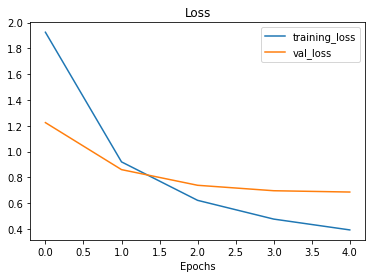

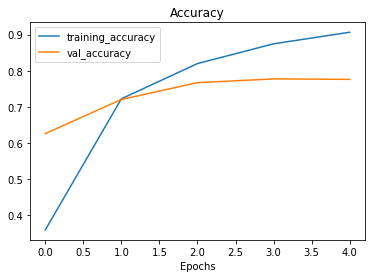

In [35]:
plot_loss_curves(resnet_history)

In [37]:
# Resnet summary 
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [38]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20220911-143223
Epoch 1/5
24/24 [==============================] - 67s 3s/step - loss: 1.9021 - accuracy: 0.3960 - val_loss: 1.3307 - val_accuracy: 0.7336
Epoch 2/5
24/24 [==============================] - 57s 2s/step - loss: 1.0802 - accuracy: 0.7747 - val_loss: 0.8829 - val_accuracy: 0.8192
Epoch 3/5
24/24 [==============================] - 57s 2s/step - loss: 0.7612 - accuracy: 0.8347 - val_loss: 0.7041 - val_accuracy: 0.8452
Epoch 4/5
24/24 [==============================] - 58s 2s/step - loss: 0.6125 - accuracy: 0.8613 - val_loss: 0.6150 - val_accuracy: 0.8596
Epoch 5/5
24/24 [==============================] - 58s 2s/step - loss: 0.5147 - accuracy: 0.8933 - val_loss: 0.5565 - val_accuracy: 0.8672


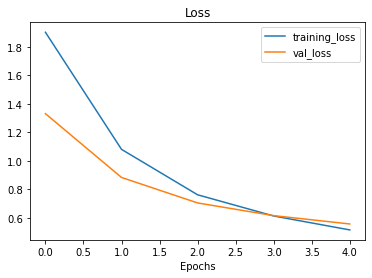

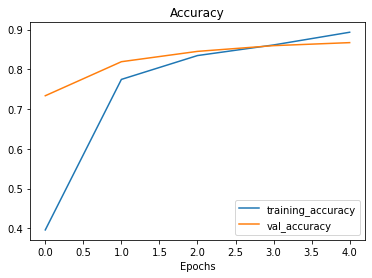

In [41]:
plot_loss_curves(efficientnet_history)

In [42]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [45]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))
  # Get the predicted class
  pred_class = class_names[pred[0].argmax()]
  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']
1/1 [==============================] - 1s 753ms/step


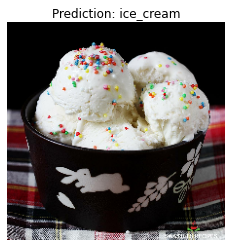

In [44]:
# Get the class names for our multi-class dataset
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)
pred_and_plot(efficientnet_model, "icecream1.jpg", class_names)